In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import sparse
import time
import os
data_paths = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/patient-switch-featurepipeline/test_feature_names.csv
/kaggle/input/patient-switch-featurepipeline/__results__.html
/kaggle/input/patient-switch-featurepipeline/train_features.npz
/kaggle/input/patient-switch-featurepipeline/custom.css
/kaggle/input/patient-switch-featurepipeline/__notebook__.ipynb
/kaggle/input/patient-switch-featurepipeline/test_features.npz
/kaggle/input/patient-switch-featurepipeline/__output__.json
/kaggle/input/patient-switch-featurepipeline/train_fitness_values.csv
/kaggle/input/patient-switch-featurepipeline/train_feature_names.csv
/kaggle/input/drug-switch-preprocessing/__results__.html
/kaggle/input/drug-switch-preprocessing/custom.css
/kaggle/input/drug-switch-preprocessing/train.parquet
/kaggle/input/drug-switch-preprocessing/__notebook__.ipynb
/kaggle/input/drug-switch-preprocessing/train_labels.parquet
/kaggle/input/drug-switch-preprocessing/test.parquet
/kaggle/input/drug-switch-preprocessing/__output__.json
/kaggle/input/drug-switch-classi

In [2]:
def save_data(data, path):
    return sparse.save_npz(path, data)

def load_data(path):
    return sparse.load_npz(path)

In [3]:
train_df = pd.read_parquet(data_paths['train.parquet'])
print(train_df.shape, train_df.columns)

(14446880, 7) Index(['patient_id', 'event_name', 'event_time', 'specialty', 'plan_type',
       'patient_payment', 'id'],
      dtype='object')


In [4]:
target_df = pd.read_parquet(data_paths['train_labels.parquet'])
print(target_df.shape, target_df.columns)

(16683, 3) Index(['patient_id', 'outcome_flag', 'id'], dtype='object')


In [5]:
train_features = load_data(data_paths['train_features.npz'])
train_features.data = np.nan_to_num(train_features.data, copy=False)
train_features = train_features.tocsr()
train_features.shape

(16683, 41525)

In [6]:
train_labels= target_df['outcome_flag'].values
train_labels.shape

(16683,)

In [7]:
test_df = pd.read_parquet(data_paths['test.parquet'])
print(test_df.shape, test_df.columns)

(6256130, 7) Index(['patient_id', 'event_name', 'event_time', 'specialty', 'plan_type',
       'patient_payment', 'id'],
      dtype='object')


In [8]:
test_features = load_data(data_paths['test_features.npz'])
test_features.data = np.nan_to_num(test_features.data, copy=False)
test_features = test_features.tocsr()
test_features.shape

(7148, 41525)

### Modelling - LGBM

In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.1,
    'learning_rate': 0.01,
    'max_depth': 97,
    'metric':'auc',
    'min_data_in_leaf': 61,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 19,
    'num_threads': 8,
    # 'is_unbalance': True,
    'scale_pos_weight': 11,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': -1,
    'reg_alpha': 50,  # L1 weight reg
    'reg_lambda': 0,  # L2 weight reg
}

In [10]:
# imp_df = pd.read_csv(data_paths['kfold_feature_importance.csv'])
# imp_df.sort_values(["importance"], inplace = True)
# imp_df.reset_index(drop = 1)
# imp_df['importance'].hist(bins = 50)
# imp_feat_idx = sorted(imp_df[imp_df['importance'] > 0]['0'].tolist())
# len(imp_feat_idx)

In [11]:
# train_features = train_features[:,imp_feat_idx]
# test_features = test_features[:,imp_feat_idx]
# train_features.shape, test_features.shape

In [12]:
# define kFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019)

# to store
y_test_pred = np.zeros(test_features.shape[0])
feature_importance_df = pd.DataFrame(np.arange(train_features.shape[1]))
feature_importance_df["importance"] = 0

# train, validate & predict on test
start = time.time()
for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_features, train_labels)):
    print("\nStarting Fold {}/{}".format(fold_+1, n_splits))
    
    trn_data = lgb.Dataset(train_features[trn_idx,:], label=train_labels[trn_idx])
    val_data = lgb.Dataset(train_features[val_idx,:], label=train_labels[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, 
                    early_stopping_rounds = 250)
    
    feature_importance_df['importance'] += clf.feature_importance()/n_splits    
    y_test_pred += clf.predict(test_features, num_iteration=clf.best_iteration)/n_splits
    
feature_importance_df.to_csv('kfold_feature_importance.csv', index = False)


Starting Fold 1/10
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.871326	valid_1's auc: 0.79542
[1000]	training's auc: 0.90496	valid_1's auc: 0.807521
[1500]	training's auc: 0.926557	valid_1's auc: 0.811915
[2000]	training's auc: 0.943595	valid_1's auc: 0.816134
[2500]	training's auc: 0.954906	valid_1's auc: 0.818579
Early stopping, best iteration is:
[2414]	training's auc: 0.953445	valid_1's auc: 0.819067

Starting Fold 2/10
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.869991	valid_1's auc: 0.793961
[1000]	training's auc: 0.904866	valid_1's auc: 0.802413
[1500]	training's auc: 0.927967	valid_1's auc: 0.809029
[2000]	training's auc: 0.94377	valid_1's auc: 0.811302
Early stopping, best iteration is:
[1770]	training's auc: 0.936768	valid_1's auc: 0.811806

Starting Fold 3/10
Training until validation scores don't improve for 250 rounds
[500]	training's auc: 0.869495	valid_1's auc: 0.818436
[1000]	training's 

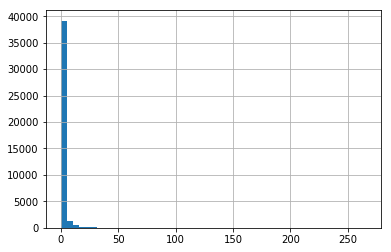

In [13]:
feature_importance_df.sort_values(["importance"], inplace = True)
feature_importance_df.reset_index(drop = 1)
feature_importance_df['importance'].hist(bins = 50)

In [14]:
pred_df = pd.DataFrame(data = sorted(test_df['id'].unique()), columns = ['id'])
pred_df['label'] = y_test_pred

In [15]:
sub_df = pd.read_csv(data_paths['Sample Submission.csv'])
sub_df['id'] = sub_df['patient_id'].apply(lambda x:int(x.split('_')[1]))
sub_df = sub_df.merge(pred_df, on='id', how='left')
sub_df = sub_df.drop(['outcome_flag', 'id'], axis = 1)
sub_df.columns = ['patient_id', 'outcome_flag']
sub_df.head()

,patient_id,outcome_flag
0,patient_2,0.588378
1,patient_3,0.607473
2,patient_5,0.887084
3,patient_8,0.052613
4,patient_14,0.865316


In [16]:
pd.Series(sub_df['outcome_flag'] >= 0.5).value_counts()

False    4636
True     2512
Name: outcome_flag, dtype: int64

In [17]:
from IPython.display import FileLink

# xlsx
filename = "BestScore.xlsx"
sub_df.to_excel(filename, index = False)
FileLink(filename)

/kaggle/working/BestScore.xlsx

In [18]:
#08 - pos = 70
#09 - pos = 25
#10 - pos = 16, num_leaves = 16, ff = 0.052, md:97
#12 - pos = 11